# Evaluation, Prediction & Visualization for the Best Model

In [1]:
import sys
import os
from os import pardir, getcwd
from os.path import join, abspath
PARENT_DIRECTORY = abspath(join(getcwd(), pardir))
sys.path.insert(0, PARENT_DIRECTORY)

import warnings
import sklearn.exceptions
import numpy as np
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

from definitions import TALOS_DIR
from app.preprocessing import (load_dataset,
                               load_embeddings,
                               preprocess_data,
                               save_embeddings_matrix)
from app.models import (load_bi_gru_model, 
                        load_bi_lstm_model, 
                        find_best_model_over_scan_logs)

from app.visualization import (plot_prediction_metrics,
                               create_clf_report,
                               plot_confusion_matrix)

#Comment out In case of Testing use only a set of the tags as dataset
# tags_categories = ['c', 'python', 'java']
# RUN_STATE = 'testing'

#Comment out In case of Production use all the tags of the dataset
tags_categories = "__all__"
RUN_STATE = 'production'


Using TensorFlow backend.


In [2]:
data = load_dataset(tags_categories=tags_categories, load_from_pickle=True)
classes_counts =data['tags'].value_counts().where(lambda cls: cls > 0).dropna() 
Classes = list(classes_counts.index)
Nclasses = len(Classes)
print(classes_counts, Classes, Nclasses)

sql              2000
ruby-on-rails    2000
android          2000
angularjs        2000
asp.net          2000
c                2000
c#               2000
c++              2000
css              2000
html             2000
ios              2000
iphone           2000
java             2000
javascript       2000
jquery           2000
mysql            2000
objective-c      2000
php              2000
python           2000
.net             2000
Name: tags, dtype: int64 ['sql', 'ruby-on-rails', 'android', 'angularjs', 'asp.net', 'c', 'c#', 'c++', 'css', 'html', 'ios', 'iphone', 'java', 'javascript', 'jquery', 'mysql', 'objective-c', 'php', 'python', '.net'] 20


 ### Hyper parameter tuning for the  model

In [3]:
# 80% Train & 20% Test
# 70% Train-Dev % 30* Train-Dev 
embeddings_voc, embeddings_vec = load_embeddings(load_from_pickle=True)
model_data = preprocess_data(data,
                             'tags',
                             'post',
                             cv_split_full=0.2,
                             cv_split_dev=0.125)

### Find the Best Model Against the Talos Scans

In [4]:

# RNN BiGRU Talos configuration filepath 
TALOS_BiGRU_DEEP_LOG_FILENAME = 'talos_bigru_deep_log_.csv'
talos_bigru_deep_log_pathname = os.path.join(TALOS_DIR, TALOS_BiGRU_DEEP_LOG_FILENAME)

TALOS_BiGRU_DEEP_MUTLI_LOG_FILENAME = 'talos_bigru_deep_multi_log_.csv'
talos_bigru_deep_multi_log_pathname = os.path.join(TALOS_DIR, TALOS_BiGRU_DEEP_MUTLI_LOG_FILENAME)

# RNN BiLSTM Talos configuration filepath
TALOS_LSTM_DEEP_LOG_FILENAME = 'talos_lstm_deep_log_.csv'
talos_lstm_deep_log_pathname = os.path.join(TALOS_DIR, TALOS_LSTM_DEEP_LOG_FILENAME)

TALOS_LSTM_DEEP_MULTI_LOG_FILENAME = 'talos_lstm_deep_multi_log_.csv'
talos_lstm_deep_multi_log_pathname = os.path.join(TALOS_DIR, TALOS_LSTM_DEEP_MULTI_LOG_FILENAME)

best_model_params = find_best_model_over_scan_logs('val_f1', *[talos_bigru_deep_log_pathname,
                                                               talos_bigru_deep_multi_log_pathname,
                                                               talos_lstm_deep_log_pathname,
                                                               talos_lstm_deep_multi_log_pathname])


    Check the model type and load the relevant processed data

In [5]:
best_model_params

{'accuracy': 0.9859877264451008,
 'batch_size': 64,
 'categorical_accuracy': 0.8488979592323304,
 'dense': 300,
 'early_stopping': True,
 'early_stopping_config__min_delta': 0,
 'early_stopping_config__mode': 'max',
 'early_stopping_config__monitor': 'val_f1',
 'early_stopping_config__patience': 5,
 'embedding_dim': 300,
 'embeddings_dropout': 0.2,
 'embeddings_matrix_path': 'embeddings-matrix-pickle',
 'epochs': 10,
 'f1': 0.8538340422085353,
 'gru_size': 200,
 'loss': 0.43310776121762334,
 'lstm_size': nan,
 'mlp_activation': 'softmax',
 'mlp_dropout': 0.2,
 'model_type': 'keras_deep_BiGRU_multi_model',
 'multistack_run': True,
 'optimizer': 'Nadam',
 'precision': 0.8905173421587262,
 'recall': 0.8205714285616972,
 'rnn_activation': 'tanh',
 'round_epochs': 10,
 'val_accuracy': 0.9836571091924396,
 'val_categorical_accuracy': 0.8202857144219535,
 'val_f1': 0.8294249632017953,
 'val_loss': 0.5932302953175136,
 'val_precision': 0.8653684859275818,
 'val_recall': 0.7968571429933821,
 'v

In [6]:

if best_model_params['model_type'] in ["keras_deep_BiGRU_model",
                                       "keras_deep_BiGRU_multi_model"]:
    talos_model_method = load_bi_gru_model

elif best_model_params['model_type'] in ["keras_deep_LSTM_model", 
                                         "keras_deep_LSTM_multi_model"]:
    talos_model_method = load_bi_lstm_model

    Train the model with the best params

In [7]:
# Add logging of each epoch run for the generation process of the best MLP Model
best_model_params['visualize_process'] = True
model_history, model = talos_model_method(model_data['x_train'],
                                          model_data['y_train'],
                                          model_data['x_train_dev'],
                                          model_data['y_train_dev'],
                                          best_model_params)

W0716 20:57:17.003571 139946386442048 deprecation_wrapper.py:119] From /home/giannhs/miniconda3/envs/text_analytics/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0716 20:57:17.028534 139946386442048 deprecation_wrapper.py:119] From /home/giannhs/miniconda3/envs/text_analytics/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0716 20:57:17.168255 139946386442048 deprecation_wrapper.py:119] From /home/giannhs/miniconda3/envs/text_analytics/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0716 20:57:17.177926 139946386442048 deprecation_wrapper.py:119] From /home/giannhs/miniconda3/envs/text_analytics/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:17

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 600)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 600, 300)          6000600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 600, 300)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 600, 400)          601200    
_________________________________________________________________
deep_attention_1 (DeepAttent [(None, 400), (None, 600) 160801    
_________________________________________________________________
dense_1 (Dense)              (None, 300)               120300    
_________________________________________________________________
dense_2 (Dense)              (None, 20)                6020      
Total para


Epoch 00001: val_accuracy improved from -inf to 0.96930, saving model to keras_deep_BiGRU_multi_model

Epoch 00001: val_f1 improved from -inf to 0.60814, saving model to keras_deep_BiGRU_multi_model



Epoch 00002: val_accuracy improved from 0.96930 to 0.97859, saving model to keras_deep_BiGRU_multi_model

Epoch 00002: val_f1 improved from 0.60814 to 0.75481, saving model to keras_deep_BiGRU_multi_model



Epoch 00003: val_accuracy improved from 0.97859 to 0.97889, saving model to keras_deep_BiGRU_multi_model

Epoch 00003: val_f1 improved from 0.75481 to 0.76609, saving model to keras_deep_BiGRU_multi_model



Epoch 00004: val_accuracy improved from 0.97889 to 0.98069, saving model to keras_deep_BiGRU_multi_model

Epoch 00004: val_f1 improved from 0.76609 to 0.78700, saving model to keras_deep_BiGRU_multi_model



Epoch 00005: val_accuracy did not improve from 0.98069

Epoch 00005: val_f1 improved from 0.78700 to 0.78913, saving model to keras_deep_BiGRU_multi_model



Epoch 00006: val_accuracy improved from 0.98069 to 0.98169, saving model to keras_deep_BiGRU_multi_model

Epoch 00006: val_f1 improved from 0.78913 to 0.80082, saving model to keras_deep_BiGRU_multi_model



Epoch 00007: val_accuracy improved from 0.98169 to 0.98174, saving model to keras_deep_BiGRU_multi_model

Epoch 00007: val_f1 improved from 0.80082 to 0.80351, saving model to keras_deep_BiGRU_multi_model



Epoch 00008: val_accuracy improved from 0.98174 to 0.98199, saving model to keras_deep_BiGRU_multi_model

Epoch 00008: val_f1 improved from 0.80351 to 0.80583, saving model to keras_deep_BiGRU_multi_model



Epoch 00009: val_accuracy did not improve from 0.98199

Epoch 00009: val_f1 did not improve from 0.80583



Epoch 00010: val_accuracy improved from 0.98199 to 0.98205, saving model to keras_deep_BiGRU_multi_model

Epoch 00010: val_f1 improved from 0.80583 to 0.80804, saving model to keras_deep_BiGRU_multi_model



 ### Visualize Model History Scores

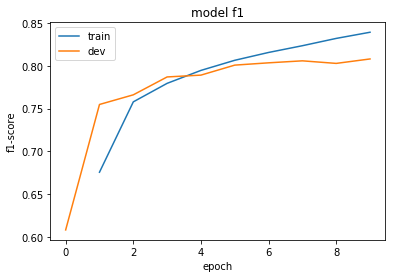

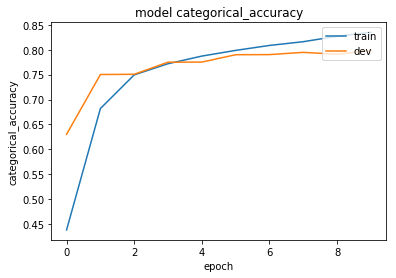

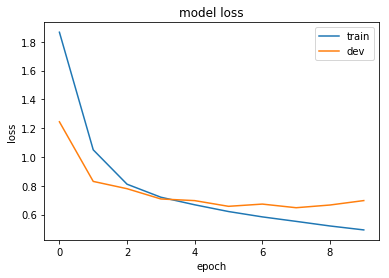

In [8]:
from app.visualization import plot_history_metrics
%matplotlib inline
plot_history_metrics(model_history)

### Evaluate performance model

Evaluates the performance of the best trained model in the **test** dataset. 

In [9]:
score = model.evaluate(model_data['x_test'],
                       model_data['y_test'],
                       batch_size=best_model_params['batch_size'],
                       verbose=1)

print('\nTest f1: %.4f' % (score[1]))
print('\nTest categorical accuracy: %.4f'% (score[2]))

8000/8000 [==============================] - 124s 16ms/step

Test f1: 0.8565

Test categorical accuracy: 0.7539


### Visualize Prediction Perfomance of centroids RNN model

--------------------------------------------------------------------------------
Accuracy Score: 78.69%
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Classification Report:

              precision    recall  f1-score   support

           0      0.859     0.580     0.693       400
           1      0.961     0.802     0.875       400
           2      0.987     0.938     0.962       400
           3      0.806     0.715     0.758       400
           4      0.837     0.845     0.841       400
           5      0.719     0.575     0.639       400
           6      0.966     0.630     0.762       400
           7      0.880     0.828     0.853       400
           8      0.818     0.688     0.747       400
           9      0.811     0.515     0.630       400
          10      0.826     0.570     0.675       400
          11      0.881     0.833     0.856       400
       

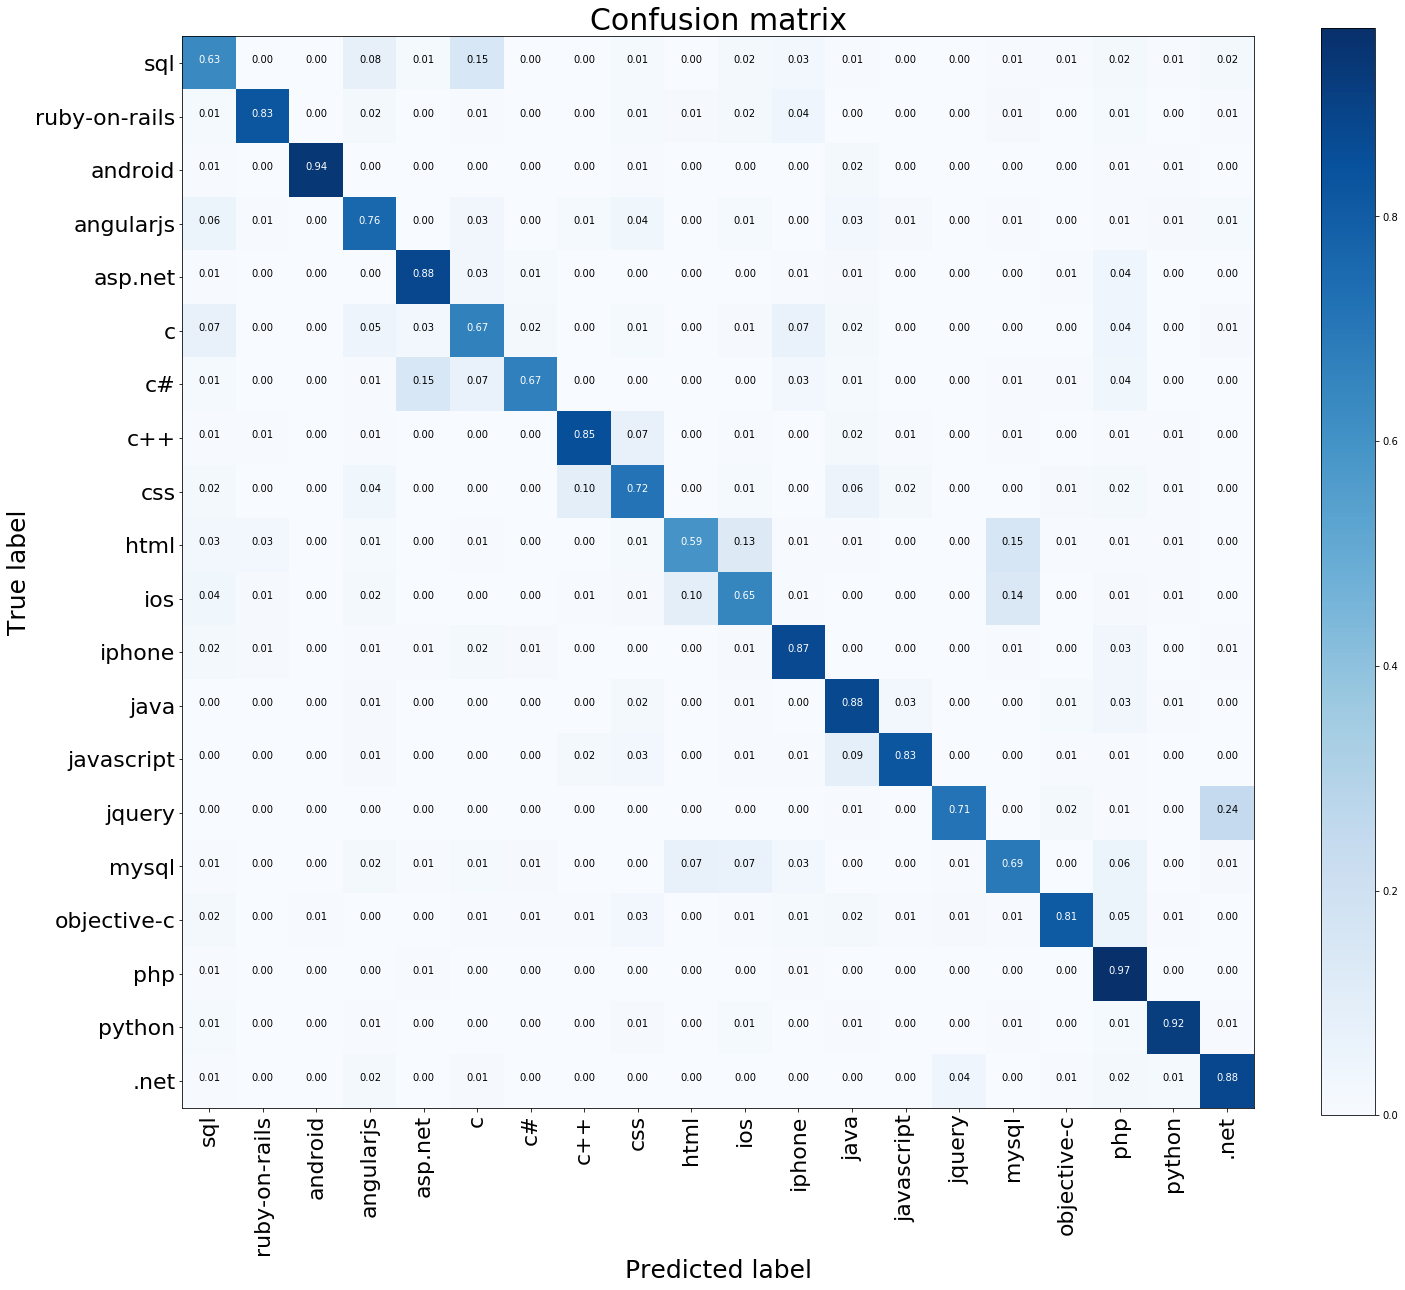

In [10]:
import numpy as np
from app.visualization import (plot_prediction_metrics,
                               create_clf_report,
                               plot_roc_curve,
                               plot_precision_recall_curve,
                               plot_confusion_matrix)
import matplotlib.pylab as plt

prediction_val = model.predict(model_data['x_test'], batch_size=best_model_params['batch_size'])

# returns each entry result to the classification with the relevant probabilities
y_pred_processed = np.array([np.argmax(val) for val in prediction_val])
y_true_processed = np.array([np.argmax(val) for val in model_data['y_test']])

# If you want to see the OneVSAll ROC Curves of each class uncomment the below line
# plot_roc_curve(model_data['y_test'], prediction_val, Classes, 1)

# If you want to see the OneVSAll Precission Recall Curves of each class, comment out the below line
# plot_precision_recall_curve(model_data['y_test'], prediction_val, Classes , 1)

# If you want to get the Classification Report, comment out the below line
create_clf_report(model_data['y_test'], (prediction_val > 0.5).astype('int32'),
                  y_true_processed, y_pred_processed)

# If you want to get the confusion matrix,comment out the below line
plot_confusion_matrix(y_true_processed, y_pred_processed, Classes)